In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 70%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 90%; }
</style>
"""))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn import metrics
from sklearn.metrics import roc_auc_score,accuracy_score
import random
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from multiprocessing.pool import Pool # 进程池
from utils import *

In [5]:
# dataset_list = ['assist2009','algebra2005','bridge2algebra2006','nips_task34','peiyou','ednet']
dataset_list = ['algebra2005','peiyou','ednet']
model_list = ['iekt','qdkt','akt']
model_root_dir = "/mnt/cfs/project2/full_result_pykt/best_model_path"

## 读取原始的预测结果

In [6]:
df_dict_raw,report_list_raw = load_pred_result(model_list,dataset_list,model_root_dir)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
df_report = pd.DataFrame(report_list_raw)
df_report['auc+std'] = df_report.apply(lambda x:f"{x['auc']:>.4f}±{x['std']:>.4f}",axis=1)
df_pivot = pd.pivot_table(df_report,index=['model_name'],columns=['dataset'],values=['auc+std'],aggfunc=sum,sort=False).fillna("-")['auc+std']
df_pivot

dataset,algebra2005,peiyou,ednet
model_name,,,
iekt,0.8416±0.0014,0.8280±0.0002,0.7335±0.0014
qdkt,0.7485±0.0017,0.8225±0.0002,0.6987±0.0010
akt,0.8306±0.0019,0.8207±0.0008,0.6721±0.0022


In [8]:
num_repeat = 10

In [9]:
df_dict,report_list = sample_dataset(model_list,dataset_list,df_dict_raw,num_repeat=num_repeat,num_sample=10000)

In [10]:
df_report = pd.DataFrame(report_list)
df_report['auc+std'] = df_report.apply(lambda x:f"{x['auc']:>.4f}±{x['std']:>.4f}",axis=1)
df_pivot = pd.pivot_table(df_report,index=['model_name'],columns=['dataset'],values=['auc+std'],aggfunc=sum,sort=False).fillna("-")['auc+std']
df_pivot

dataset,algebra2005,peiyou,ednet
model_name,,,
iekt,0.8407±0.0035,0.8290±0.0035,0.7323±0.0056
qdkt,0.7540±0.0064,0.8236±0.0039,0.6973±0.0054
akt,0.8310±0.0041,0.8235±0.0036,0.6689±0.0037


In [11]:
len(df_dict_raw),len(df_dict)

(45, 90)

In [12]:
#确保数据没问题
data_report_list = []
for dataset in dataset_list:
    for model_name in model_list:
        for repeat_index in range(num_repeat):
            df_sample = df_dict[f'{dataset}_{model_name}_{repeat_index}']
            data_report = get_metrics(df_sample['y_true'],df_sample['y_pred'])
            data_report['model_name'] = model_name
            data_report['dataset'] = dataset
            data_report_list.append(data_report)

In [13]:
df_data_report = pd.DataFrame(data_report_list)

In [14]:
df_data_report.groupby(['dataset','model_name']).mean()

acc       auc
dataset            model_name                   
algebra2005        akt         0.81390  0.831013
                   dkt         0.80871  0.813821
                   sakt        0.79265  0.783482
assist2009         akt         0.73811  0.787173
                   dkt         0.72331  0.750957
                   sakt        0.70214  0.720648
bridge2algebra2006 akt         0.86119  0.821858
                   dkt         0.85762  0.803378
                   sakt        0.84702  0.775583
ednet              akt         0.66760  0.668871
                   dkt         0.64035  0.609579
                   sakt        0.64460  0.609827
nips_task34        akt         0.73237  0.803959
                   dkt         0.70272  0.768291
                   sakt        0.68591  0.750117
peiyou             akt         0.82622  0.823486
                   dkt         0.81679  0.785867
                   sakt        0.81157  0.770706

## 数据统计

In [14]:
# 确保数据没问题
data_report_list = []
for dataset in dataset_list:
    for model_name in model_list:
        model_report = {"model_name": model_name, "dataset": dataset}
        acc_list = []
        auc_list = []
        pos_rate_list = []
        df_sample_list = []
        for repeat_index in range(num_repeat):
            df_sample = df_dict[f'{dataset}_{model_name}_{repeat_index}']
            pos_rate_list.append(df_sample['y_true'].mean())
            data_report = get_metrics(df_sample['y_true'], df_sample['y_pred'])
            acc_list.append(data_report['acc'])
            auc_list.append(data_report['auc'])
            df_sample_list.append(df_sample)
        df_sample_merge = pd.concat(df_sample_list).drop_duplicates(
            ['qidx', 'questions', 'concepts', 'concept_preds', 'late_mean', 'y_pred'])
        model_report['Accuracy'] = f"{np.mean(acc_list):.4f}±{np.std(acc_list):.4f}"
        model_report['AUC'] = f"{np.mean(auc_list):.4f}±{np.std(auc_list):.4f}"
        model_report['Percent of positive interactions'] = f"{np.mean(pos_rate_list):.4f}±{np.std(pos_rate_list):.4f}"
        model_report['Total unique interactions'] = len(df_sample_merge)
        data_report_list.append(model_report)
#         break
#     break

KeyError: Index(['questions', 'concepts', 'concept_preds', 'qidx'], dtype='object')

In [525]:
df_data_report = pd.DataFrame(data_report_list)

In [526]:
df_pivot = pd.pivot_table(df_data_report, index=['dataset'], columns=[
                          'model_name'], aggfunc=lambda x: "".join([str(i) for i in x]), sort=False)
df_pivot

AUC                                \
model_name                    akt            dkt           sakt   
dataset                                                           
assist2009          0.7872±0.0030  0.7510±0.0039  0.7206±0.0027   
algebra2005         0.8310±0.0041  0.8138±0.0048  0.7835±0.0049   
bridge2algebra2006  0.8219±0.0040  0.8034±0.0036  0.7756±0.0039   
nips_task34         0.8040±0.0042  0.7683±0.0043  0.7501±0.0055   

                         Accuracy                                \
model_name                    akt            dkt           sakt   
dataset                                                           
assist2009          0.7381±0.0025  0.7233±0.0039  0.7021±0.0035   
algebra2005         0.8139±0.0046  0.8087±0.0033  0.7927±0.0025   
bridge2algebra2006  0.8612±0.0026  0.8576±0.0035  0.8470±0.0024   
nips_task34         0.7324±0.0039  0.7027±0.0044  0.6859±0.0063   

                   Percent of positive interactions                 \
model_name                                      akt            dkt   
dataset                                                              
assist2009                            0.6401±0.0034  0.6401±0.0034   
algebra2005                           0.7553±0.0017  0.7553±0.0017   
bridge2algebra2006                    0.8398±0.0033  0.8398±0.0033   
nips_task34                           0.5510±0.0037  0.5510±0.0037   

                                  Total unique interactions                
model_name                   sakt                       akt    dkt   sakt  
dataset                                                                    
assist2009          0.6401±0.0034                     46008  46008  46008  
algebra2005         0.7553±0.0017                     63272  63272  63272  
bridge2algebra2006  0.8398±0.0033                     88095  88095  88095  
nips_task34         0.5510±0.0037                     84943  84943  84943

In [527]:
df_data_report

,model_name,dataset,Accuracy,AUC,Percent of positive interactions,Total unique interactions
0,dkt,assist2009,0.7233±0.0039,0.7510±0.0039,0.6401±0.0034,46008
1,sakt,assist2009,0.7021±0.0035,0.7206±0.0027,0.6401±0.0034,46008
2,akt,assist2009,0.7381±0.0025,0.7872±0.0030,0.6401±0.0034,46008
3,dkt,algebra2005,0.8087±0.0033,0.8138±0.0048,0.7553±0.0017,63272
4,sakt,algebra2005,0.7927±0.0025,0.7835±0.0049,0.7553±0.0017,63272
5,akt,algebra2005,0.8139±0.0046,0.8310±0.0041,0.7553±0.0017,63272
6,dkt,bridge2algebra2006,0.8576±0.0035,0.8034±0.0036,0.8398±0.0033,88095
7,sakt,bridge2algebra2006,0.8470±0.0024,0.7756±0.0039,0.8398±0.0033,88095
8,akt,bridge2algebra2006,0.8612±0.0026,0.8219±0.0040,0.8398±0.0033,88095
9,dkt,nips_task34,0.7027±0.0044,0.7683±0.0043,0.5510±0.0037,84943


In [528]:
data_report

{'acc': 0.7347, 'auc': 0.8093286716830078}

## 置信度计算方法

### 基于概率

In [105]:
human_type_config = {"S": {
    "human_cost": 5,
    "human_correct_rate": 0.97,
    'human_level': "S"
}, "A": {
    "human_cost": 1,
    "human_correct_rate": 0.90,
    "human_level": "A"
}}

model_cost = 0.01
num_repeat = 10

In [106]:
human_dict = {}
for dataset in tqdm(dataset_list):
    for model_name in model_list:
        for repeat_index in range(num_repeat):
            y_true = df_dict[f'{dataset}_{model_name}_{repeat_index}']['y_true'].values
            for human_type in human_type_config.keys():
                # 按照占比采样
                human_info = human_type_config[human_type]
                index = np.arange(0, len(y_true))
                mask = np.arange(0, len(y_true))
                np.random.seed(human_info['human_cost']*1000)
                np.random.shuffle(mask)
                mask = mask[:int(
                    human_info['human_correct_rate'] * len(y_true))]
                human_pred = np.where(np.isin(index, mask),
                                      y_true, np.abs(y_true - 1))
                human_dict[f"{dataset}_{model_name}_{repeat_index}_{human_info['human_level']}"] = human_pred
                acc = np.mean(human_pred == y_true)
                print(acc, human_info)

  0%|          | 0/6 [00:00<?, ?it/s]

0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 

0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 

0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 5, 'human_correct_rate': 0.97, 'human_level': 'S'}
0.9 {'human_cost': 1, 'human_correct_rate': 0.9, 'human_level': 'A'}
0.97 {'human_cost': 

In [107]:
alloc_list = [{"mode": "S"}, {"mode": "A"}]#, {"mode": "average"}, {
#     "mode": "conf_average"}, {"mode": "weight_average"}, {"mode": "conf_weight_average"}

In [108]:
def get_one_report(input_data, debug=False):
    condition = input_data['condition']
    model_pred = input_data['model_pred']
    dataset = input_data['dataset']
    alloc_config = input_data['alloc_config']
    y_true = input_data['y_true']

    # 分配人类
    human_pred, human_num, roles, human_cost = allocation_humans(
        condition_model=condition,
        model_pred=model_pred,
        model_name=input_data['model'],
        repeat_index=input_data['repeat_index'],
        dataset=dataset,
        config=alloc_config,
        human_type_config=human_type_config,
        human_dict=human_dict,
        debug=debug)

    cost = human_cost + model_cost*(len(model_pred)-human_num)

    y_pred = np.where(condition, model_pred, human_pred)

    report = {
        "dataset": dataset,
        "model": input_data['model'],
        "tau": input_data['tau'],
        "auto_score_cover": 1 - roles.mean(),
        "repeat_index":input_data['repeat_index'],
        "human_num": human_num,
        "cost": cost,
        "alloc_mode": alloc_config['mode']
    }
    report.update(get_metrics(y_true, y_pred))  # 计算AUC占用96%的时间
    human_result = get_metrics(y_true, human_pred, "human_")
    model_result = get_metrics(y_true, model_pred, "model_")
    report.update(human_result)
    report.update(model_result)
    return report

In [109]:
min_tau = 0
max_tau = 1.00001
tau_step = 0.05
condition_type = "area_prob"  #area_prob
# condition_type = "class_prob"

In [110]:
input_data_list = []
for dataset in tqdm(dataset_list):
    for model in model_list:  # model
        for repeat_index in range(10):
            for alloc_config in tqdm(alloc_list, leave=False):  # 分配方法
                y_true = df_dict[f'{dataset}_{model}_{repeat_index}']['y_true'].values
                model_pred = df_dict[f'{dataset}_{model}_{repeat_index}'][
                    'y_pred'].values
                # 计算不同的tau
                for tau in np.arange(min_tau, max_tau, tau_step):
                    if condition_type == 'area_prob':  # 按照0.5卡区间
                        condition = (np.abs(model_pred - 0.5) / 0.5) > tau
                    input_data = {"dataset": dataset,
                                  'model_pred': model_pred,
                                  "y_true": y_true,
                                  "repeat_index": repeat_index,
                                  "alloc_config": alloc_config,
                                  "condition": condition,
                                  "model": model,
                                  "tau": tau}
                    input_data_list.append(input_data)
len(input_data_list)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

7560

In [111]:
# report_list = []
# for input_data in tqdm(input_data_list):
#     one_report = get_one_report(input_data)
#     report_list.append(one_report)

In [112]:
%%time
p = Pool(10)
report_list = p.map(get_one_report, input_data_list)
p.close()

CPU times: user 120 ms, sys: 1.53 s, total: 1.65 s
Wall time: 7.91 s


In [113]:
df_report = pd.DataFrame(report_list)
df_report['Model'] = df_report['model'].map(col_map)
df_report.shape

(7560, 15)

In [114]:
# df_report[:20]

In [115]:
df_report[df_report['tau'].isin([1])].groupby(["dataset","tau","model","alloc_mode"]).mean()

auto_score_cover  repeat_index  \
dataset            tau model alloc_mode                                   
algebra2005        1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   
assist2009         1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   
bridge2algebra2006 1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   
ednet              1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   
nips_task34        1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   
peiyou             1.0 akt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       dkt   A                        0.0           4.5   
                             S                        0.0           4.5   
                       sakt  A                        0.0           4.5   
                             S                        0.0           4.5   

                                         human_num     cost   acc       auc  \
dataset            tau model alloc_mode                                       
algebra2005        1.0 akt   A             10000.0  10000.0  0.90  0.900407   
                             S             10000.0  50000.0  0.97  0.970292   
                       dkt   A             10000.0  10000.0  0.90  0.900407   
                             S             10000.0  50000.0  0.97  0.970292   
                       sakt  A             10000.0  10000.0  0.90  0.900407   
                             S             10000.0  50000.0  0.97  0.970292   
assist2009         1.0 akt   A             10000.0  10000.0  0.90  0.900249   
                             S             10000.0  50000.0  0.97  0.969818   
                       dkt   A             10000.0  10000.0  0.90  0.900249   
                             S             10000.0  50000.0  0.97  0.969818   
                       sakt  A             10000.0  10000.0  0.90  0.900249   
                             S             10000.0  50000.0  0.97  0.969818   
bridge2algebra2006 1.0 akt   A             10000.0  10000.0  0.90  0.900633   
     

In [116]:
df_report.to_csv(f"data/df_report_v2_{'-'.join(dataset_list)}.csv",index=False)

In [117]:
df_report[df_report['model']=='dkt']

,dataset,model,tau,auto_score_cover,repeat_index,human_num,cost,alloc_mode,acc,auc,human_acc,human_auc,model_acc,model_auc,Model
0,assist2009,dkt,0.00,0.9999,0,1,104.99,S,0.7214,0.747990,0.97,0.970324,0.7214,0.748058,DKT
1,assist2009,dkt,0.05,0.9511,0,489,2540.11,S,0.7443,0.773311,0.97,0.970324,0.7214,0.748058,DKT
2,assist2009,dkt,0.10,0.9042,0,958,4880.42,S,0.7632,0.795768,0.97,0.970324,0.7214,0.748058,DKT
3,assist2009,dkt,0.15,0.8540,0,1460,7385.40,S,0.7826,0.818523,0.97,0.970324,0.7214,0.748058,DKT
4,assist2009,dkt,0.20,0.8070,0,1930,9730.70,S,0.8019,0.838804,0.97,0.970324,0.7214,0.748058,DKT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6715,ednet,dkt,0.80,0.0682,9,9318,9324.82,A,0.8920,0.897747,0.90,0.899722,0.6320,0.599782,DKT
6716,ednet,dkt,0.85,0.0286,9,9714,9716.86,A,0.8981,0.899777,0.90,0.899722,0.6320,0.599782,DKT
6717,ednet,dkt,0.90,0.0036,9,9964,9964.36,A,0.9000,0.899791,0.90,0.899722,0.6320,0.599782,DKT
6718,ednet,dkt,0.95,0.0000,9,10000,10000.00,A,0.9000,0.899722,0.90,0.899722,0.6320,0.599782,DKT


## 画图

In [118]:
df_report = pd.read_csv(f"data/df_report_v2_{'-'.join(dataset_list)}.csv")

In [119]:
# sns.set_theme(context='notebook',style='white',font_scale=1.2)
# alloc_mode_list = ['S','A','B','average', 'conf_average', 'weight_average','conf_weight_average']
# # color_map = dict(zip(alloc_mode_list,sns.color_palette(n_colors=len(alloc_mode_list))))
# markers = ['*','o','^','h','8','s','p']
# color_palette = sns.color_palette("Set2",len(alloc_mode_list))
# markersize = 8
# linewidth = 2.2
# len(markers),len(alloc_mode_list)

In [ ]:
# df_report[(df_report['tau']==1)&(df_report['model']=='dkt')]

### tau 和 auc/score的关系

In [ ]:
g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
g.map(sns.lineplot, "tau","auc")
g.add_legend()
plt.savefig("data/imgs/tau-auc.pdf",bbox_inches="tight")

In [ ]:
# fig,ax = plt.figure(figsize=(10,5))
g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
g.map(sns.lineplot, "tau","cost")
g.add_legend()
plt.savefig("data/imgs/tau-cost.pdf",bbox_inches="tight")

In [ ]:
# df_report.sort_values("cost",ascending=False).drop_duplicates(["model","alloc_mode"])

In [ ]:
df_report

In [ ]:
# # fig,ax = plt.figure(figsize=(10,5))
# g = sns.FacetGrid(df_report,col="model",row='dataset', margin_titles=False,hue='alloc_mode',height=4,aspect=1.5,legend_out=True)
# g.map(sns.lineplot, "tau","auto_score_cover")
# g.add_legend()
# plt.savefig("data/imgs/tau-auto_score_cover.pdf",bbox_inches="tight")

### acc VS cost

In [120]:
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.1)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

In [121]:
alloc_mode_plot_dict = {}
for alloc_mode in ['S','A']:
    plot_list = []
    for dataset in dataset_list:
        data = df_report[(df_report['alloc_mode']==alloc_mode)&(df_report['dataset']==dataset)].copy()
        row_list = []
        for (tau,model),group in data.groupby(["tau","model"]):
            row = {"dataset":dataset,"tau":tau,"Model":col_map[model],"alloc_mode":alloc_mode,"dataset":dataset}
            row.update(group.mean().to_dict())
            row_list.append(row)
        df_plot = pd.DataFrame(row_list)
        df_plot['cost_k'] = df_plot['cost']/1000
        plot_list.append(df_plot)
    alloc_mode_plot_dict[alloc_mode] = plot_list

#### 所有数据集

In [141]:
sub_dataset_list = dataset_list
len(sub_dataset_list)

6

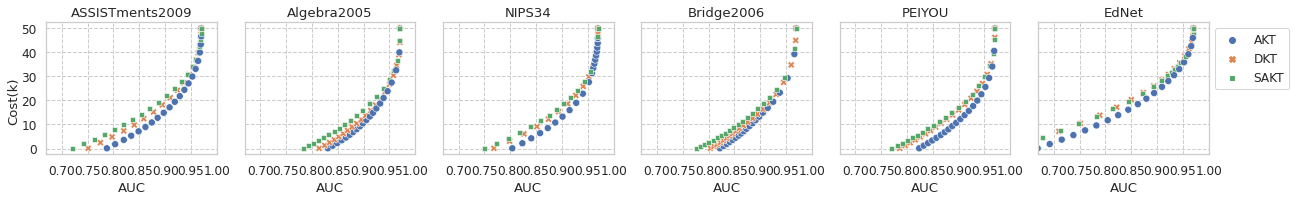

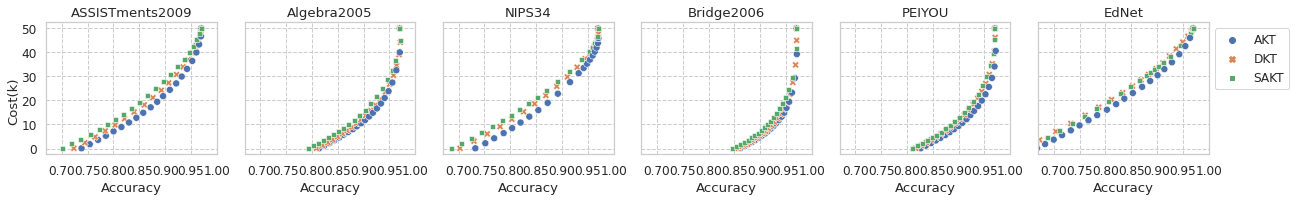

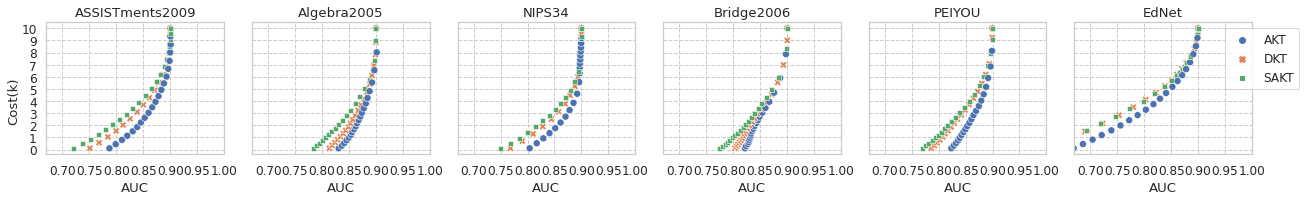

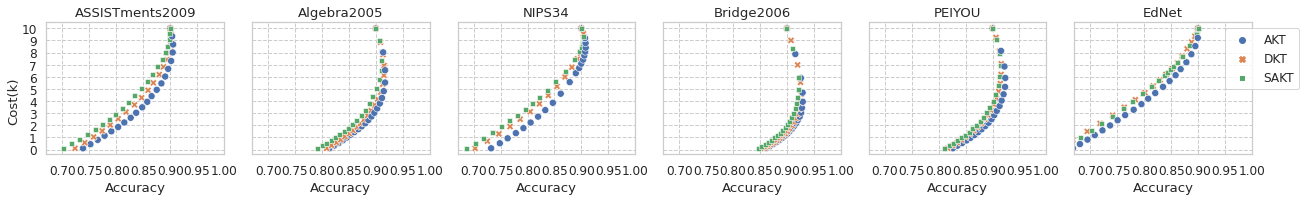

In [142]:
for alloc_mode in ['S', 'A']:
    for metric in ['auc', 'acc']:
        fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(
            len(sub_dataset_list)*3, 3), sharey=True, sharex=True)
        i = 0
        for i in range(len(sub_dataset_list)):
            dataset_index = dataset_list.index(sub_dataset_list[i])
            df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
            df_plot[df_plot['dataset'].isin(sub_dataset_list)]
            sns.scatterplot(data=df_plot, x=metric,
                            y='cost_k', hue='Model', style='Model', s=50, ax=ax[i], legend=i == len(sub_dataset_list)-1)
            ax[i].set_title(col_map[sub_dataset_list[i]])
#             ax[i].axvline(x=0.85, color='r', linestyle='-.')
            ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
            if alloc_mode == "S":
                ax[i].set_yticks(np.arange(0, 50.1, 10))
            elif alloc_mode == "A":
                ax[i].set_yticks(np.arange(0, 10.1, 1))
            ax[i].set_ylabel("")
            if metric == 'acc':
                ax[i].set_xlabel("Accuracy")
            else:
                ax[i].set_xlabel("AUC")
        plt.xlim(0.67, 1)
        plt.xlim(right=1)
        if alloc_mode == "S":
            plt.legend(bbox_to_anchor=(1, 1))
        elif alloc_mode == "A":
            plt.legend(bbox_to_anchor=(1.3, 1))
        plt.tight_layout()
    #     fig.text(0.5, 0, 'Accuracy', ha='center')
        fig.text(0, 0.5, 'Cost(k)', va='center', rotation='vertical')

        plt.savefig(
            f"data/imgs/{alloc_mode}-{metric}-cost_all_dataset.pdf", bbox_inches="tight")
#         print(f"{alloc_mode}-{metric}")
    #     break

#### 部分数据集

In [529]:
sub_dataset_list = ['assist2009',
                    'algebra2005',
                    'bridge2algebra2006','nips_task34']

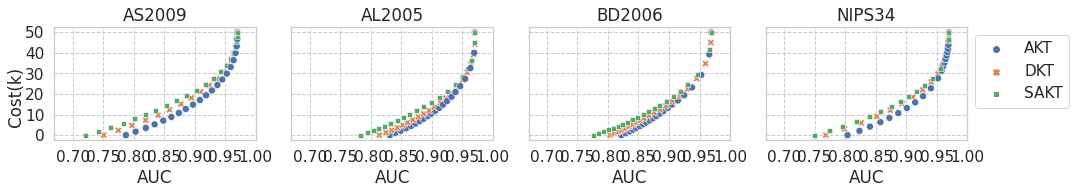

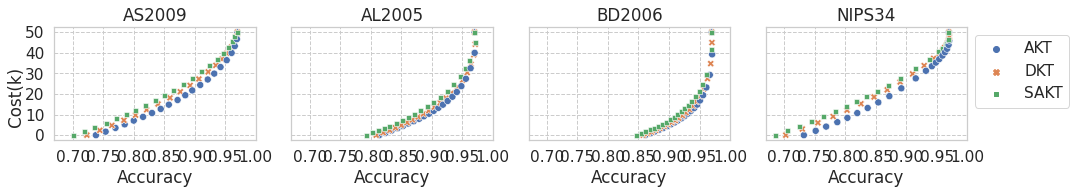

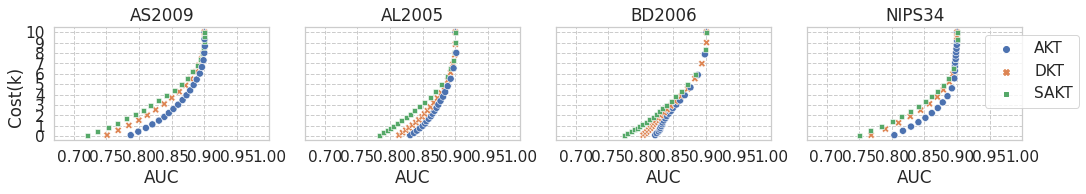

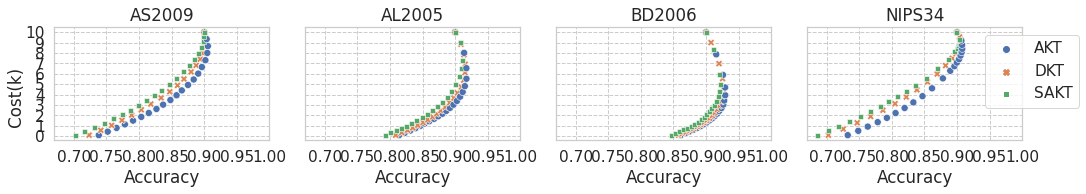

In [530]:
for alloc_mode in ['S', 'A']:
    for metric in ['auc', 'acc']:
        fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(
            15, 3), sharey=True, sharex=True)
        i = 0
        for i in range(len(sub_dataset_list)):
            dataset_index = dataset_list.index(sub_dataset_list[i])
            df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
            df_plot[df_plot['dataset'].isin(sub_dataset_list)]
            sns.scatterplot(data=df_plot, x=metric,
                            y='cost_k', hue='Model', style='Model', s=50, ax=ax[i], legend=i == len(sub_dataset_list)-1)
            ax[i].set_title(col_map[sub_dataset_list[i]])
#             ax[i].axvline(x=0.85, color='r', linestyle='-.')
            ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
            if alloc_mode == "S":
                ax[i].set_yticks(np.arange(0, 50.1, 10))
            elif alloc_mode == "A":
                ax[i].set_yticks(np.arange(0, 10.1, 1))
            ax[i].set_ylabel("")
            if metric == 'acc':
                ax[i].set_xlabel("Accuracy")
            else:
                ax[i].set_xlabel("AUC")
        plt.xlim(0.67, 1)
        plt.xlim(right=1)
        if alloc_mode == "S":
            plt.legend(bbox_to_anchor=(1, 1))
        elif alloc_mode == "A":
            plt.legend(bbox_to_anchor=(1.3, 1))
        plt.tight_layout()
    #     fig.text(0.5, 0, 'Accuracy', ha='center')
        fig.text(0, 0.5, 'Cost(k)', va='center', rotation='vertical')

        plt.savefig(
            f"data/imgs/{alloc_mode}-{metric}-cost.pdf", bbox_inches="tight")
#         print(f"{alloc_mode}-{metric}")
    #     break

In [126]:
# df_06 =  alloc_mode_plot_dict[alloc_mode][3]

In [127]:
# df_06[df_06['Model']=='AKT']

#### S/A搞在一起_部分数据集 单轴

In [145]:
df_plot.head()

,dataset,tau,Model,alloc_mode,auto_score_cover,repeat_index,human_num,cost,acc,auc,human_acc,human_auc,model_acc,model_auc,cost_k
0,bridge2algebra2006,0.00,AKT,A,0.99996,4.5,0.4,100.396,0.86123,0.821891,0.45574,0.660467,0.86119,0.821858,0.100396
1,bridge2algebra2006,0.00,DKT,A,0.99998,4.5,0.2,100.198,0.85763,0.803388,0.30772,0.579938,0.85762,0.803378,0.100198
2,bridge2algebra2006,0.00,SAKT,A,0.99999,4.5,0.1,100.099,0.84703,0.775592,0.23461,0.540031,0.84702,0.775583,0.100099
3,bridge2algebra2006,0.05,AKT,A,0.98160,4.5,184.0,282.160,0.86825,0.824046,0.90000,0.900633,0.86119,0.821858,0.282160
4,bridge2algebra2006,0.05,DKT,A,0.98455,4.5,154.5,252.955,0.86369,0.806409,0.90000,0.900633,0.85762,0.803378,0.252955


In [531]:
model_name_map ={
'DKT+S': "Adv w. DKT",
'DKT+A': "Int w. DKT",
'SAKT+S': "Adv w. SAKT",
'SAKT+A': "Int w. SAKT",
'AKT+S': "Adv w. AKT",
'AKT+A': "Int w. AKT"
}
# color_map = dict(zip(model_list,list(sns.color_palette(n_colors=3))))
color_map = {
'Adv w. DKT': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
'Int w. DKT': (0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
'Adv w. SAKT': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
'Int w. SAKT': (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
'Adv w. AKT': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
'Int w. AKT': (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
'S':(0,0, 0),
'A':(0,0, 0)  
            }
marker_map = {
'Adv w. DKT': "D",
'Int w. DKT': "P",
'Adv w. SAKT': "D",
'Int w. SAKT': "P",
'Adv w. AKT': "D",
'Int w. AKT': "P",
'S':"D",
'A':"P",
}
# https://matplotlib.org/stable/api/markers_api.html

In [532]:
sns.color_palette(n_colors=10)

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [588]:
sns.set_theme(context='notebook',style='whitegrid',font_scale=1.5)
sns.set_style("whitegrid", {"grid.linestyle": "--"})

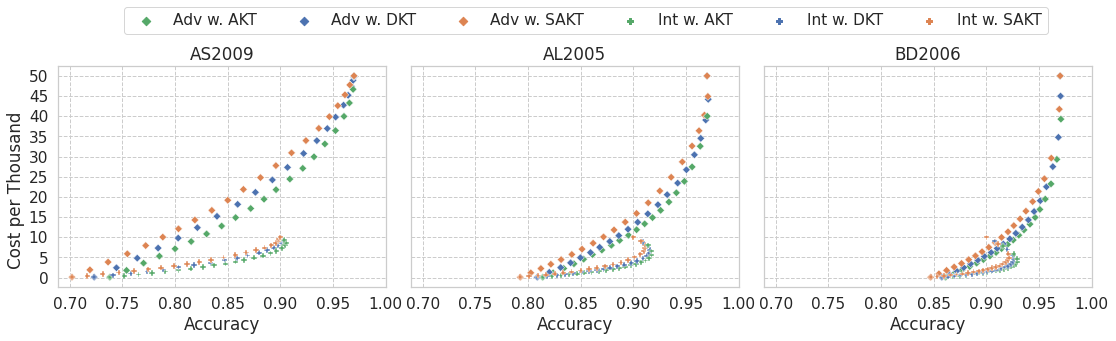

In [520]:
metric = "acc"
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 4), sharey=True, sharex=True)
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x=metric,
                    y='cost_k', hue='Model', style='Model', s=30, ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_yticks(np.arange(0, 50.1, 5))
    ax[i].set_xlabel("Accuracy")
    ax[i].set_ylabel("")
plt.tight_layout(pad=0)
plt.legend(bbox_to_anchor=(0.89, 1.3),ncol=6)
fig.text(-0.02, 0.5, 'Cost per Thousand', va='center', rotation='vertical')
plt.savefig(
    f"data/imgs/SA-{metric}-cost.pdf", bbox_inches="tight")

#### 2*2  S/A搞在一起_部分数据集 单轴

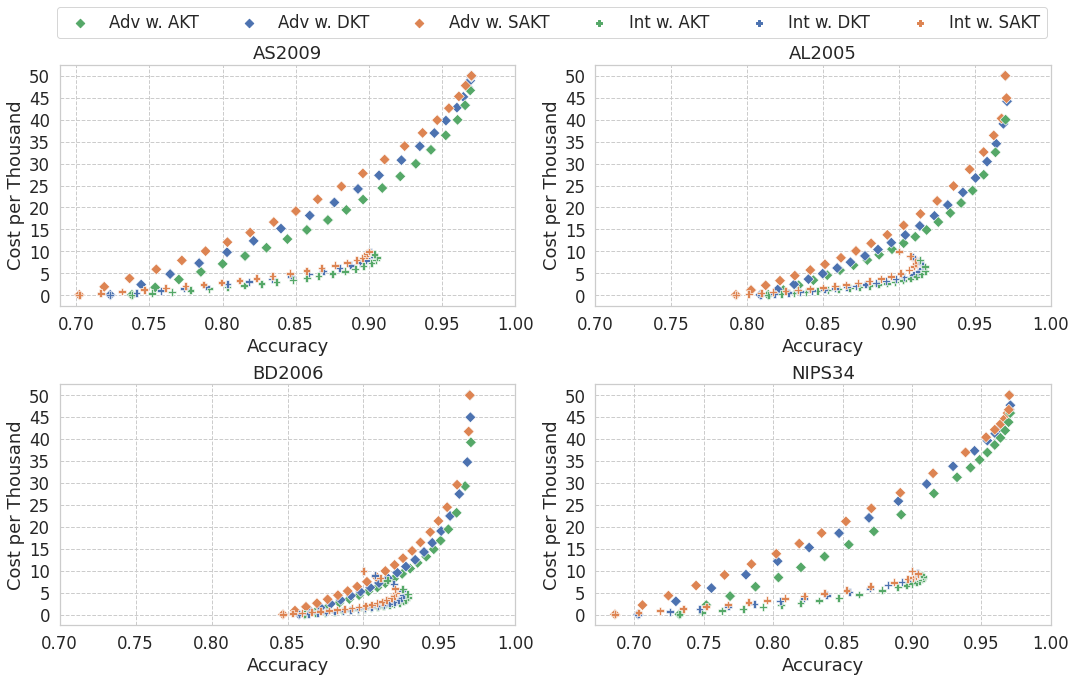

In [599]:
metric = "acc"
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15, 9))
ax = ax.flatten()
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x=metric,
                    y='cost_k', hue='Model', style='Model', s=60, ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_xticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_yticks(np.arange(0, 50.1, 5))
    ax[i].set_xlabel("Accuracy")
    ax[i].set_ylabel("Cost per Thousand")
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(1.01, 2.6),ncol=6)
plt.savefig(
    f"data/imgs/4-dataset-SA-{metric}-cost.pdf", bbox_inches="tight")

#### S/A搞在一起_部分数据集 双轴

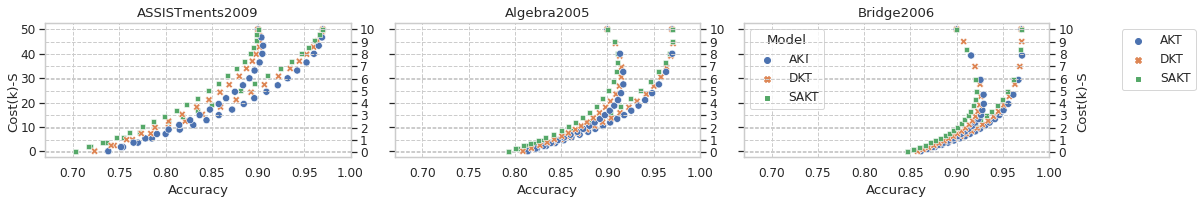

In [147]:
metric = "acc"
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 3), sharey=True, sharex=True)
for alloc_mode in ['S', 'A']:
    i = 0
    for i in range(len(sub_dataset_list)):
        dataset_index = dataset_list.index(sub_dataset_list[i])
        df_plot = alloc_mode_plot_dict[alloc_mode][dataset_index]
        df_plot[df_plot['dataset'].isin(sub_dataset_list)]
        sub_ax = ax[i]
        if alloc_mode == "A":
            sub_ax = ax[i].twinx()
        sns.scatterplot(data=df_plot, x=metric,
                        y='cost_k', hue='Model', style='Model', s=50, ax=sub_ax, legend=i == len(sub_dataset_list)-1)
        if alloc_mode == "S":
            sub_ax.set_title(col_map[sub_dataset_list[i]])
            sub_ax.set_xticks(np.arange(0.7, 1.01, 0.05))
            sub_ax.set_ylabel("")
            sub_ax.set_xlabel("Accuracy")
        else:
#             sub_ax.set_ylabel("Cost(k)-A")
            sub_ax.set_ylabel("")
        if alloc_mode == "S":
            sub_ax.set_yticks(np.arange(0, 50.1, 10))
        elif alloc_mode == "A":
            sub_ax.set_yticks(np.arange(0, 10.1, 1))
plt.xlim(0.67, 1)
plt.tight_layout(pad=1)
fig.text(0, 0.5, 'Cost(k)-S', va='center', rotation='vertical')
fig.text(0.99, 0.5, 'Cost(k)-S', va='center', rotation='vertical')
plt.legend(bbox_to_anchor=(1.5, 1))

plt.savefig(
    f"data/imgs/SA-double-ax-{metric}-cost.pdf", bbox_inches="tight")

In [38]:
!rm img.zip
!zip img.zip -r data/imgs

  adding: data/imgs/ (stored 0%)
  adding: data/imgs/.ipynb_checkpoints/ (stored 0%)
  adding: data/imgs/S-auc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-auc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/S-acc-cost.pdf (deflated 14%)
  adding: data/imgs/S-acc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-acc-cost.pdf (deflated 14%)
  adding: data/imgs/S-auc-cost.pdf (deflated 14%)
  adding: data/imgs/A-acc-cost_all_dataset.pdf (deflated 10%)
  adding: data/imgs/A-auc-cost.pdf (deflated 14%)


### 覆盖率 VS AUC&Cost

In [ ]:
# sns.set_theme(context='notebook',style='whitegrid',font_scale=1.1)
# sns.set_style("whitegrid", {"grid.linestyle": "--"})

#### remove cost

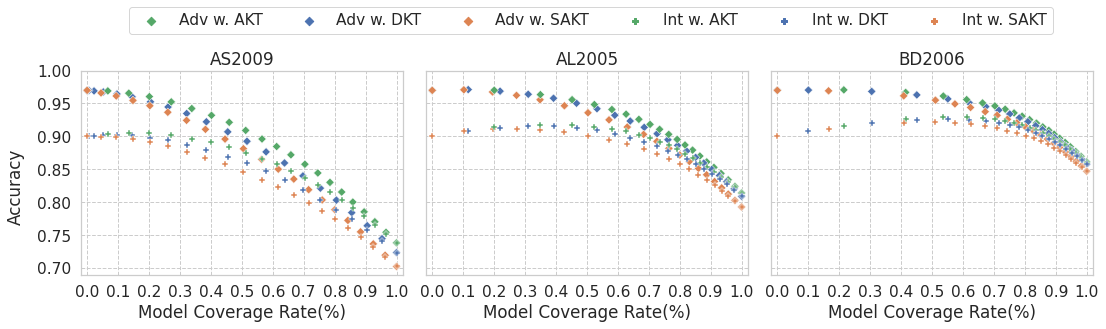

In [521]:
fig, ax = plt.subplots(1, len(sub_dataset_list), figsize=(15, 4), sharey=True, sharex=True)
i = 0

for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x='auto_score_cover',
                    y='acc'
                 , hue='Model', style='Model', 
                 ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_yticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_xticks(np.arange(0, 1.01, 0.1))
    ax[i].set_xlabel("Model Coverage Rate(%)")
    ax[i].set_ylabel("")
plt.xlim(-0.02,1.02)
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(0.9, 1.35),ncol=6)
fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
plt.savefig(
    f"data/imgs/SA-auto_score_cover-acc.pdf", bbox_inches="tight")

#### 2*2 remove cost

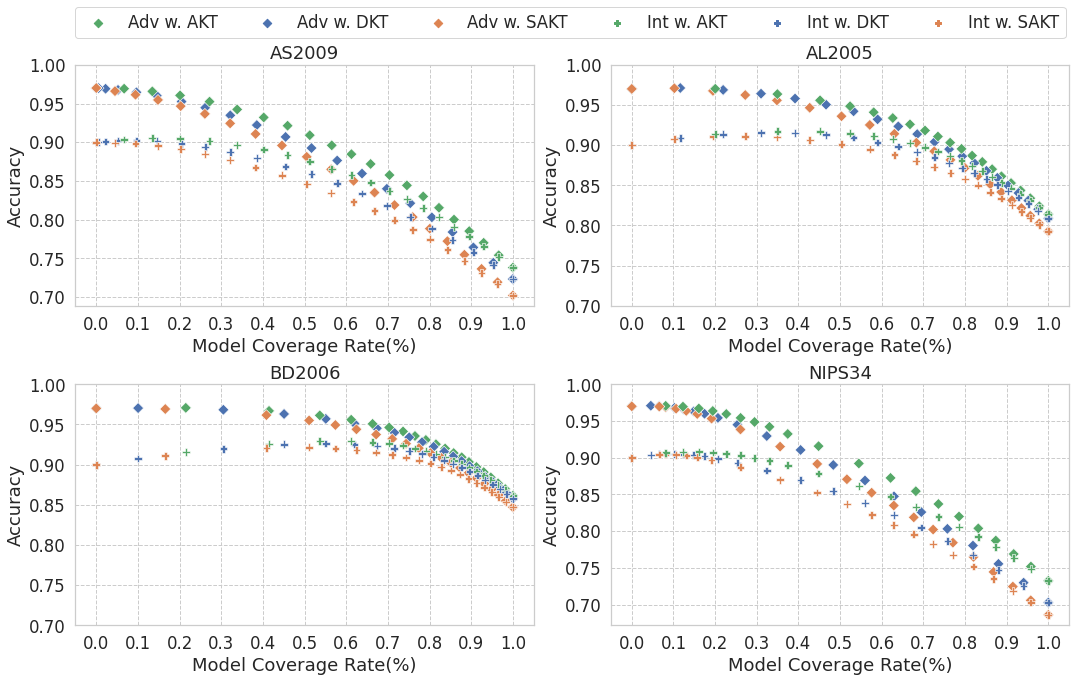

In [600]:
fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(15, 9))
ax = ax.flatten()
i = 0
for i in range(len(sub_dataset_list)):
    dataset_index = dataset_list.index(sub_dataset_list[i])
    df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
    df_plot_a = alloc_mode_plot_dict['A'][dataset_index]
    
    df_plot = pd.concat([df_plot_s,df_plot_a])
    df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
    df_plot['Model'] = df_plot['Model'].map(model_name_map)
    df_plot[df_plot['dataset'].isin(sub_dataset_list)]

    sns.scatterplot(data=df_plot, x='auto_score_cover',
                    y='acc'
                 , hue='Model', style='Model', 
                 ax=ax[i], legend=i == len(sub_dataset_list)-1,
                    palette = color_map,markers=marker_map,
                    s=60,
                   )
    ax[i].set_title(col_map[sub_dataset_list[i]])
    ax[i].set_yticks(np.arange(0.7, 1.01, 0.05))
    ax[i].set_xticks(np.arange(0, 1.01, 0.1))
    ax[i].set_xlabel("Model Coverage Rate(%)")
    ax[i].set_ylabel("Accuracy")
plt.tight_layout(pad=0.5)
plt.legend(bbox_to_anchor=(1.01, 2.6),ncol=6)
plt.savefig(
    f"data/imgs/4-dataset-SA-auto_score_cover-acc.pdf", bbox_inches="tight")

#### keep cost

In [456]:
import matplotlib.lines as mlines

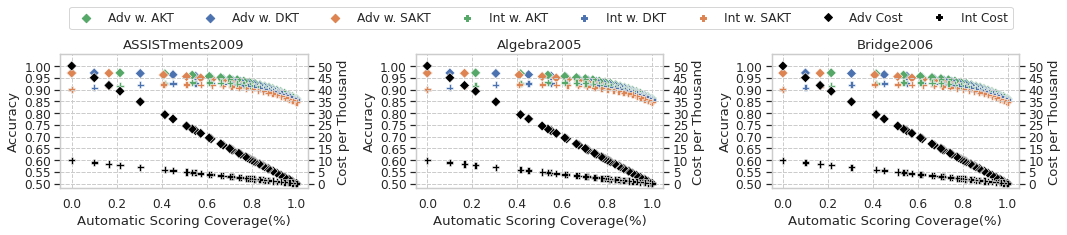

In [457]:
fig, ax = plt.subplots(1, len(sub_dataset_list),
                       figsize=(15, 3), sharey=False, sharex=True)

df_tmp = None
for plot_col in ['acc', 'cost']:
    i = 0
    for i in range(len(sub_dataset_list)):
        df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
        df_plot_a = alloc_mode_plot_dict['A'][dataset_index]

        df_plot = pd.concat([df_plot_s, df_plot_a])
        df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
        df_plot['Model'] = df_plot['Model'].map(model_name_map)
        df_plot[df_plot['dataset'].isin(sub_dataset_list)]
        sub_ax = ax[i]
        if plot_col == "acc":
            sns.scatterplot(data=df_plot, x='auto_score_cover',
                            y='acc', hue='Model', style='Model', s=50, ax=sub_ax,
                            legend=i == len(sub_dataset_list)-1, palette=color_map, markers=marker_map
                            )
        else:
            sub_ax = ax[i].twinx()
            df_plot['auto_score_cover_round'] = df_plot['auto_score_cover'].apply(
                lambda x: round(x, 2))
            df_plot = df_plot.drop_duplicates(
                ['alloc_mode', 'auto_score_cover_round'])
            sns.scatterplot(data=df_plot, x='auto_score_cover',
                            y='cost_k', hue='alloc_mode', style='alloc_mode', s=50, ax=sub_ax,
                            legend=False, palette=color_map, markers=marker_map
                            )
            df_tmp = df_plot

        sub_ax.set_xlabel("Automatic Scoring Coverage(%)")
        if plot_col == "acc":
            sub_ax.set_title(col_map[sub_dataset_list[i]])
            sub_ax.set_ylabel("Accuracy")

        else:
            sub_ax.set_ylabel("Cost per Thousand")

        if plot_col == "acc":
            sub_ax.set_yticks(np.arange(0.5, 1.05, 0.05))
            sub_ax.set_ylim(0.5-0.0198, 1.05)
        elif plot_col == "cost":
            #             sub_ax.set_yticks(np.arange(0, 50.1, 5))
            sub_ax.set_yticks(np.arange(0, 55, 5))
            sub_ax.set_ylim(-1.979, 55)
plt.tight_layout(pad=1)
handles, labels = ax[-1].get_legend_handles_labels()
cost_s_marker = mlines.Line2D([], [], color='black', marker='D',
                              label='Adv Cost',linewidth=0)
cost_a_marker = mlines.Line2D([], [], color='black', marker='P',
                              label='Int Cost',linewidth=0)
handles.extend([cost_s_marker, cost_a_marker])
labels.extend(['Adv Cost', 'Int Cost'])
ax[-1].legend(handles=handles, labels=labels,
              bbox_to_anchor=(1, 1.4), ncol=8)
plt.savefig(
    f"data/imgs/SA-auto_score_cover_add_cost-acc.pdf", bbox_inches="tight")

In [370]:
len(np.arange(0.65, 1, 0.05))

7

In [367]:
((1-0.65)/0.03-11)*0.02

0.013333333333333322

In [ ]:
==11

In [330]:
(1-0.6)/x = 11

0.03636363636363637

In [356]:
55*0.036

1.9799999999999998

In [359]:
(1.1-0.55)*0.036

0.0198

In [355]:
2/55

0.03636363636363636

In [333]:
len(np.arange(0, 55, 5))

11

In [ ]:
# fig, ax = plt.subplots(1, len(sub_dataset_list),
#                        figsize=(15, 3.3), sharey=True, sharex=True)
# i = 0

# for i in range(len(sub_dataset_list)):
#     dataset_index = dataset_list.index(sub_dataset_list[i])
#     df_plot_s = alloc_mode_plot_dict['S'][dataset_index]
#     df_plot_a = alloc_mode_plot_dict['A'][dataset_index]

#     df_plot = pd.concat([df_plot_s, df_plot_a])
#     df_plot['Model'] = df_plot['Model']+"+"+df_plot['alloc_mode']
#     df_plot['Model'] = df_plot['Model'].map(model_name_map)
#     df_plot[df_plot['dataset'].isin(sub_dataset_list)]

#     sns.scatterplot(data=df_plot, x='auto_score_cover',
#                     y='acc', hue='Model', style='Model',
#                     ax=ax[i], legend=i == len(sub_dataset_list)-1,
#                     palette=color_map, markers=marker_map
#                     )
#     ax[i].set_title(col_map[sub_dataset_list[i]])
#     ax[i].set_yticks(np.arange(0.7, 1.01, 0.05))
#     ax[i].set_xticks(np.arange(0, 1.01, 0.1))
#     ax[i].set_xlabel("Automatic Scoring Coverage(%)")
#     ax[i].set_ylabel("")
# plt.xlim(-0.02, 1.02)
# plt.tight_layout(pad=0.5)
# plt.legend(bbox_to_anchor=(0.53, 1.3), ncol=6)
# fig.text(-0.02, 0.5, 'Accuracy', va='center', rotation='vertical')
# # plt.savefig(
# #     f"data/imgs/SA-auto_score_cover-acc.pdf", bbox_inches="tight")

### min_auc VS cost

In [ ]:
e_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    min_value = round(df_report['auc'].min()-0.01, 2)
    for e in np.arange(min_value, 0.95001, 0.01):
        e = round(e, 3)
        group = group[group['auc'] >= e].sort_values("cost")
        if len(group) != 0:
            row = group.iloc[0]
            e_report = row.to_dict()
            e_report['min_auc'] = e
            e_report_list.append(e_report)

In [ ]:
df_e_report = pd.DataFrame(e_report_list)
df_e_report.shape

In [ ]:
df_e_report[:10]

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_e_report[(df_e_report['model']==model)&(df_e_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="min_auc", y="cost", hue="alloc_mode", style="alloc_mode", markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,
                    )
        plt.xlabel("Minimum AUC")
        plt.ylabel("Cost")
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.legend(bbox_to_anchor=(1, 1))
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_min_auc-cost.pdf",bbox_inches="tight")
#         break
#     break

### min_auc VS cost 限制单个成本

In [ ]:
df_report

In [ ]:
max_cost_list = np.arange(0,10.01,1)
max_cost_list

In [ ]:
max_cost_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    y_true = df_dict[f'{dataset}_dkt_0']['y_true'].values
    num_inter = len(y_true)
    group['avg_cost'] = group['cost']/num_inter
    for max_cost in max_cost_list:
        sub_group = group[group['avg_cost'] <= max_cost].sort_values("auc",ascending=False)
        if len(sub_group) != 0:
            row = sub_group.iloc[0]
            max_cost_report = row.to_dict()
            max_cost_report['max_cost'] = max_cost
            max_cost_report_list.append(max_cost_report)

In [ ]:
df_max_cost_report = pd.DataFrame(max_cost_report_list)
df_max_cost_report.shape

In [ ]:
df_max_cost_report.head()

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_max_cost_report[(df_max_cost_report['model']==model)&(df_max_cost_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="max_cost", y="auc", hue="alloc_mode", style="alloc_mode", markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,)
        plt.legend(bbox_to_anchor=(1, 1))
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.xlabel("Cost")
        plt.ylabel("AUC")
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_max_cost-auc.pdf",bbox_inches="tight")
#         break
#     break

### min_auc VS cost 限制总成本

In [ ]:
df_report

In [ ]:
dataset_max_cost_list = {"peiyou":[1e6,1.5e6,1e7,1.5e7,1e8],"assist2009":[1e4,1.5e4,1e5,1.5e5,1e6]}

In [ ]:
max_cost_report_list = []
for (dataset, model, human_level, fold), group in df_report.groupby(['dataset', 'model', 'alloc_mode', 'fold'], sort=False):
    y_true = df_dict[f'{dataset}_dkt_0']['y_true'].values
    max_cost_list = dataset_max_cost_list[dataset]
    for max_cost in max_cost_list:
        sub_group = group[group['cost'] <= max_cost].sort_values("auc",ascending=False)
        if len(sub_group) != 0:
            row = sub_group.iloc[0]
            max_cost_report = row.to_dict()
            max_cost_report['max_cost'] = max_cost
            max_cost_report_list.append(max_cost_report)

In [ ]:
df_max_cost_report = pd.DataFrame(max_cost_report_list)
df_max_cost_report.shape

In [ ]:
df_max_cost_report

In [ ]:
for dataset in dataset_list:
    for model in model_list:
        data = df_max_cost_report[(df_max_cost_report['model']==model)&(df_max_cost_report['dataset']==dataset)]
        plt.figure(figsize=(10,5))
        sns.lineplot(data=data, x="max_cost", y="auc", hue="alloc_mode",
                     markers=markers,
                     markersize=markersize,
                     linewidth=linewidth,
                     palette=color_palette,
                     style="alloc_mode",)
        plt.legend(bbox_to_anchor=(1, 1))
        sns.despine(left=False, bottom=False)  # 移除边框线
        plt.xlabel("Cost")
        plt.ylabel("AUC")
#         plt.title(f"{dataset}-{model}")
        plt.savefig(f"data/imgs/{dataset}-{model}_max_total_cost-auc.pdf",bbox_inches="tight")
#         break
#     break

In [ ]:
df_max_cost_report['alloc_mode'].unique()